## Covariate example

In [1]:
from pyesbm.baseline import BaseESBM
from pyesbm.priors import GnedinProcess, DirichletProcess
from pyesbm.likelihoods import PoissonGamma, BetaBernoulli
from pyesbm.covariates import BaseCovariate, CategoricalCovariate, CountCovariate
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pyesbm.utilities.plotting_functions import plot_heatmap
from pyesbm.utilities.vi_functs import VI
from pyesbm.utilities.misc_functs import generate_bernoulli_data, generate_poisson_data

The ESBM allows the use of covariates to supervise the Gibbs sampler. In our collapsed Gibbs sampler, the cluster assignment of node $u$ is drawn from a categorical distribution with probability:
$$
\mathbb{P}(z_u = h \mid \mathbf{Y}, \mathbf{X}, \mathbf{z}_{-u}) \propto \mathbb{P}(z_u = h \mid \mathbf{z}_{-u}) 
\frac{p(\mathbf{X}_{h})}{p(\mathbf{X}_{h, -u})} 
\frac{p(\mathbf{Y} \mid z_u = h, \mathbf{z}_{-u})}{p(\mathbf{Y}_{-u} \mid \mathbf{z}_{-u})}
$$
The term $\frac{p(\mathbf{X}_{h})}{p(\mathbf{X}_{h, -u})}$ s a covariate-dependent similarity function that measures the homogeneity of cluster $h$ with respect to the external covariates.

There is substantial theory on this topic (e.g., Müller et al., 2011; Quintana et al., 2015). At a high level, this similarity function is chosen so that more homogeneous clusters receive higher values, thereby guiding the Gibbs sampler toward partitions that are more coherent in terms of $\mathbf{X}$

### Example on unipartite graph

The rest of the notebook presents an application of ESBM to clustering with the use of count and categorical covariates for a unipartite graph

In [2]:
n = 100

# manually define clustering structure
sizes = [n//5, n//10, n//3, n//4, n - (n//3)-(n//4)-(n//5)-(n//10)]
clustering = np.array(
    [0 for _ in range(sizes[0])] + 
    [1 for _ in range(sizes[1])] + 
    [2 for _ in range(sizes[2])] + 
    [3 for _ in range(sizes[3])] +
    [4 for _ in range(sizes[4])])

rng = np.random.default_rng(42)

Y = generate_poisson_data(0.5, 
                          0.5,
                          clustering, 
                          bipartite=False, 
                          rng=rng)

a = np.random.permutation(n)
clustering = clustering[a]
Y = Y[a][:, a]

We create covariates following the clustering structure (plus some noise) such that true clusters are (more or less) homogeneous.

In [3]:
cov_values = np.array([1 if clustering[i]%2==0 else 0 for i in range(n)])
# add some noise
cov_values[np.random.randint(0, len(cov_values), size=25)] = 2

cov1 = CountCovariate(name='count', cov_array=cov_values, a=2, b=5)
cov2 = CategoricalCovariate(name='cat', cov_array=cov_values, alpha_c=1)
cov3 = CategoricalCovariate(name='cat2', cov_array=cov_values, alpha_c=1)

Here we apply the model to count-valued data hence we use a Poisson-Gamma model. The prior for the clustering structure chosen here is a Dirichlet Process prior. 

-4188.212793809347


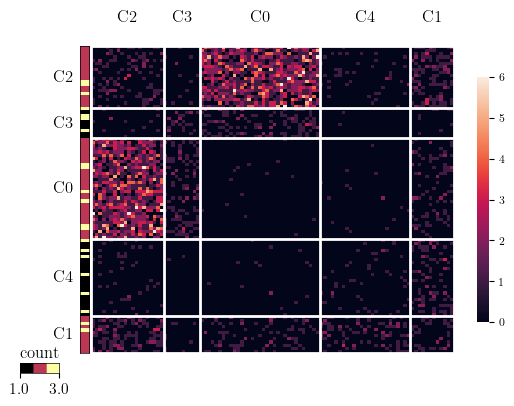

In [4]:
prior_shape = 1
prior_rate = 1

prior = DirichletProcess(concentration=2)

likelihood = PoissonGamma(shape=prior_shape, rate=prior_rate)

# instantiate covariate class

gen_model = BaseESBM(Y, 
              prior=prior, 
              clustering=clustering,
              likelihood=likelihood,
              covariates_1=[cov1, cov2, cov3], 
              bipartite=False)

print(gen_model.compute_log_likelihood())
plot_heatmap(gen_model, size=(6,4), bipartite=False, triangular_mask=False)

In [5]:
rng = np.random.default_rng(12)

# n = 5
# Y = Y[:n, :n]
# covs = [('genre_categorical', t3[:n].copy()) for _ in range(1)]

bb = BaseESBM(Y, 
              prior=prior, 
              likelihood=likelihood,
              covariates_1=[cov1, cov2],
              epsilon=1e-10, 
              bipartite=False, 
              verbose=False, 
              clustering='Random',
              rng=rng)

# plot_heatmap(bb, size=(6, 5), bipartite=False, triangular_mask=False)

out = bb.fit(n_iters=100, verbose=True)

starting log likelihood -7132.543178521588
0 -5393.685194559789
time 2.116060333006317
10 -4188.212793809348
time 0.1452294170157984
20 -4188.212793809348
time 0.13794966699788347
30 -4188.212793809348
time 0.14327720800065435
40 -4188.212793809348
time 0.14492141699884087
50 -4188.212793809348
time 0.1475617089890875
60 -4188.212793809348
time 0.16838445799658075
70 -4188.212793809348
time 0.15692483299062587
80 -4188.212793809348
time 0.1419096250028815
90 -4188.212793809348
time 0.13991041699773632
end llk:  -4188.212793809348


We can now evaluate our fit of the model using
- a visual inspection of the estimated clustering structure (with comparison to the true one)
- the Variation of Information metric (the lower the better, zero means perfect recovery)

[0.]


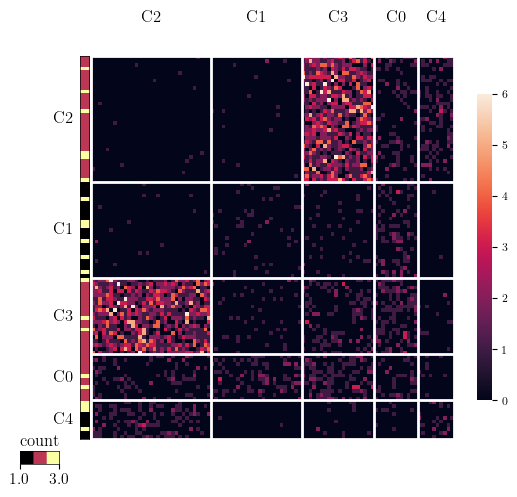

In [6]:
estimated = bb.estimate_cluster_assignment_vi(burn_in=20)
cl1 = estimated[0]
cl2 = estimated[2]
print(VI(clustering, cl1))

plot_heatmap(bb, size=(6, 5), bipartite=True, triangular_mask=True)